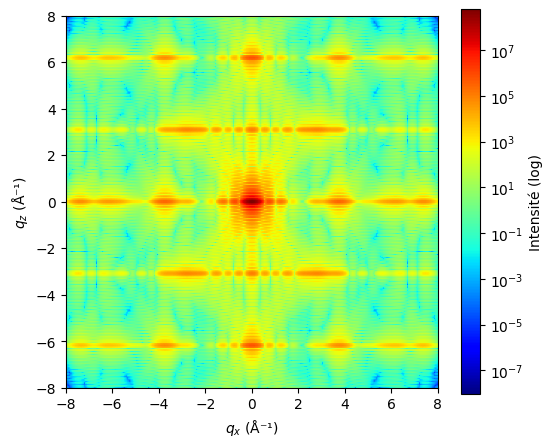

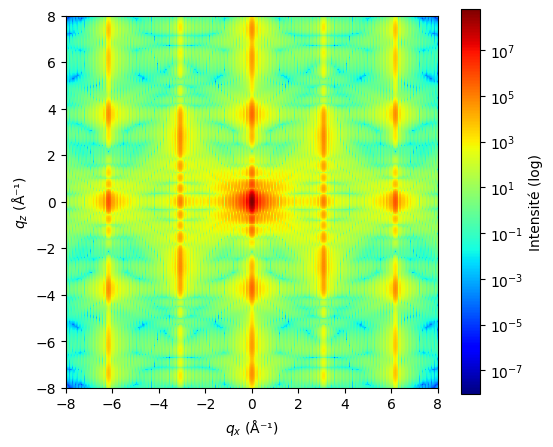

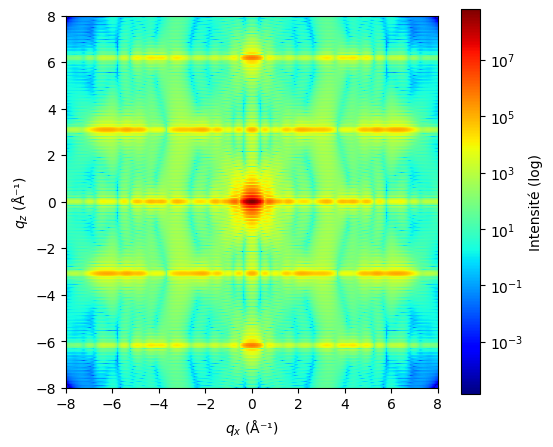

In [1]:
from NPScattering2D import NanoparticleScattering2D
from ase.cluster import Decahedron
from ase.io import write

atoms = Decahedron('Fe',5,20,0)
atoms.write('./test.xyz')


# Créer la classe
np_scatter = NanoparticleScattering2D('test.xyz', qmax=8.0, npix=250)

# Intensité pour orientation par défaut
I_map = np_scatter.compute_intensity()
np_scatter.plot_intensity(I_map)

# Calcul pour 2 orientations différentes
angles_list = [
    (0, 90, 0),
    (90, 90, 0)
    ]
for angles in angles_list:
    np_scatter.positions = np_scatter.rotate_positions(*angles)
    I_map = np_scatter.compute_intensity()
    np_scatter.plot_intensity(I_map)



